In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,BB_SMA,BB_STD,Upper_Band,Lower_Band,MACD_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
2259,64.383331,65.324997,64.303329,65.285004,4089600,63.930057,63.410579,0.519478,0.393097,0.126381,62.894583,1.492309,64.386892,61.402275,NaN,NaN,NaN,0,NaN,NaN
2260,64.639999,65.035004,63.836666,64.440002,6755400,64.042651,63.521868,0.520783,0.418872,0.101911,63.097417,1.436269,64.533685,61.661148,1.0,0.0,1.0,0,0.003987,0.000000
2261,64.716667,65.480003,64.595001,64.769997,5623200,64.149043,63.627997,0.521046,0.439458,0.081587,63.232667,1.455873,64.688540,61.776794,1.0,-1.0,0.0,0,0.005177,0.000000
2262,64.906670,65.078331,63.666668,63.981667,5548200,64.268155,63.739634,0.528521,0.457377,0.071145,63.380417,1.468914,64.849331,61.911503,1.0,-1.0,0.0,0,0.008128,0.000000
2263,66.831665,67.019997,65.101669,65.338333,7317000,64.669830,64.005369,0.664461,0.498990,0.165471,63.630833,1.609657,65.240490,62.021177,1.0,-1.0,0.0,0,0.038027,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,197.119995,198.449997,194.880005,195.000000,4820900,190.639556,187.419519,3.220037,3.079932,0.140106,190.148999,3.973678,194.122677,186.175321,-1.0,-1.0,-2.0,-1,2.061662,0.003308
3236,194.070007,197.250000,193.470001,195.220001,3360600,191.167318,187.894554,3.272764,3.118498,0.154266,190.417999,4.051060,194.469059,186.366939,1.0,-1.0,0.0,0,2.014290,0.003308
3237,197.110001,199.500000,194.110001,194.110001,3544900,192.081577,188.552800,3.528777,3.200554,0.328223,190.866499,4.275889,195.142388,186.590611,1.0,0.0,1.0,0,2.061507,0.003308
3238,199.600006,200.880005,198.199997,199.000000,3306200,193.238258,189.341886,3.896372,3.339718,0.556655,191.420000,4.657020,196.077020,186.762980,1.0,-1.0,0.0,0,2.100181,0.003308


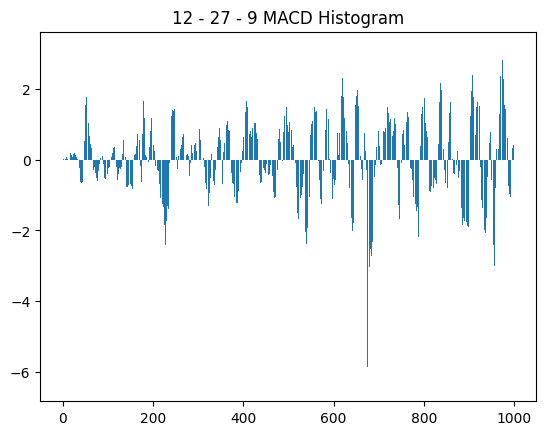

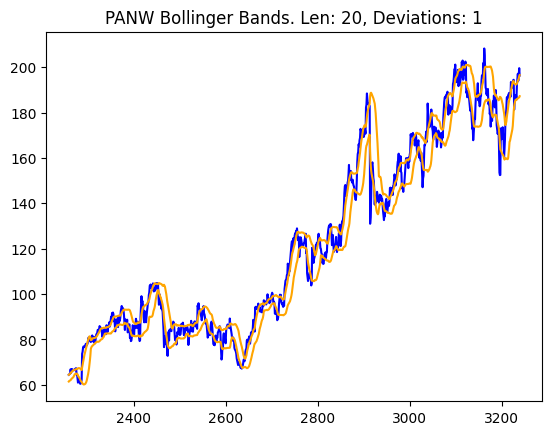

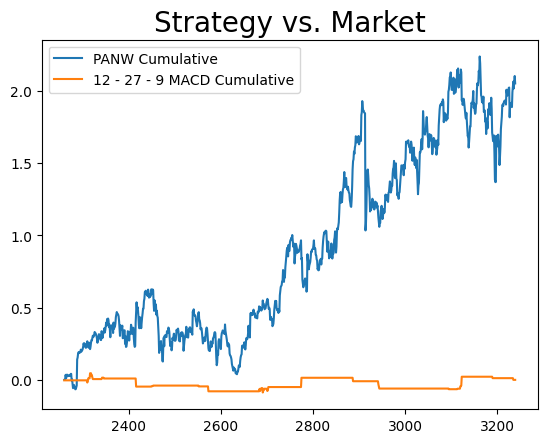

In [2]:
TICKER = 'PANW'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
BB_LEN = 20
DEVS = 1

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    
    return df

def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df